In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import numpy as np
import xlsxwriter
from openpyxl import load_workbook

from ipynb.fs.full.UtilCollections import CURRENT_TEAMS, PARAMS, SEASONS, TEAM_STATS
from ipynb.fs.full.UtilFunctions import merge_standings, format_season, spearman_rank_corr

In [51]:
SEASONS = SEASONS[3:]

In [3]:
pylab.rcParams.update(PARAMS)

In [35]:
def calculate_rank_corr_by_player_stat(df, eastern_standings, western_standings, stat, measure="mean"): #measure might be mean, sd or max
    if measure == "mean":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).mean())
    elif measure == "sd":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).std())
    elif measure == "max":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).max())
    grouped_df.sort_values(by=[stat, 'Tm'], ascending=[False, True], inplace=True)
    
    teams = list(grouped_df.index)
    if "TOT" in teams:
        teams.remove("TOT")
    
    rank = range(1, 31)
    teams_ordered_by_stat = dict(zip(teams, rank))
    standings = merge_standings(eastern_standings, western_standings)
        
    rank1 = []
    rank2 = []
    for team in CURRENT_TEAMS:
        if team in standings:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings[team])

    return spearman_rank_corr(rank1, rank2)

In [37]:
def calculate_rank_corr_by_team_stat(df, eastern_standings, western_standings, stat):
    
    corr_df = df.sort_values(by=[stat, 'Team'], ascending=[False, True])
    
    corr_df.set_index('Team', inplace=True)
    
    teams = list(corr_df.index)
    rank = range(1, 31)
    teams_ordered_by_stat = dict(zip(teams, rank))
    
    standings = merge_standings(eastern_standings, western_standings)
    
    
    rank1 = []
    rank2 = []
    for team in CURRENT_TEAMS:
        if team in standings:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings[team])

    return spearman_rank_corr(rank1, rank2)

In [6]:
def rank_player_corrs_to_excel(dfs, eastern_standings_dfs, western_standings_dfs, stat, measure="mean"):
    corrs = [stat, measure]
    
    for i in range(len(dfs)):
        corrs.append(calculate_rank_corr_by_player_stat(dfs[i], eastern_standings_dfs[i], western_standings_dfs[i], stat, measure))
        
    wb = load_workbook("Rank_Correlation_Player_Stats.xlsx")
    ws = wb.worksheets[0]    
    ws.append(corrs)
    wb.save("Rank_Correlation_Player_Stats.xlsx")

In [44]:
def rank_team_corrs_to_excel(dfs, eastern_standings_dfs, western_standings_dfs, stat):
    corrs = [stat]
    
    for i in range(len(dfs)):
        corrs.append(calculate_rank_corr_by_team_stat(dfs[i], eastern_standings_dfs[i], western_standings_dfs[i], stat))
        
    wb = load_workbook("DataCollection/Correlation/Rank_Correlation_Team_Stats.xlsx")
    ws = wb.worksheets[0]    
    ws.append(corrs)
    wb.save("DataCollection/Correlation/Rank_Correlation_Team_Stats.xlsx")

In [10]:
def get_csvs_by_season(season):
    first_year, second_year = format_season(season)

    player_df = pd.read_csv("DataCollection/Player_Stats/player_stats_{0}-{1}.csv".format(first_year, second_year))
    team_df = pd.read_csv("DataCollection/Team_Stats/team_stats_{0}-{1}.csv".format(first_year, second_year))
    adv_team_df = pd.read_csv("DataCollection/Advanced_Team_Stats/adv_team_stats_{0}-{1}.csv".format(first_year, second_year))
    opponent_df = pd.read_csv("DataCollection/Opponent_Stats/opponent_stats_{0}-{1}.csv".format(first_year, second_year))
    eastern_standings_df = pd.read_csv("DataCollection/Standings/standings_eastern_conference_{0}-{1}.csv".format(first_year, second_year))
    western_standings_df = pd.read_csv("DataCollection/Standings/standings_western_conference_{0}-{1}.csv".format(first_year, second_year))

    return player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df

In [29]:
player_dfs, team_dfs, adv_team_dfs, opponent_dfs, eastern_standings_dfs, western_standings_dfs = [], [], [], [], [], []

for season in SEASONS:
    player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df = get_csvs_by_season(season)
    player_dfs.append(player_df)
    team_dfs.append(team_df)
    adv_team_dfs.append(adv_team_df)
    opponent_dfs.append(opponent_df)
    eastern_standings_dfs.append(eastern_standings_df)
    western_standings_dfs.append(western_standings_df)

In [33]:
complete_team_dfs = []

for i in range(len(team_dfs)):
    complete_team_dfs.append(pd.merge(team_dfs[i], adv_team_dfs[i]))

In [45]:
for stat in TEAM_STATS:
    rank_team_corrs_to_excel(complete_team_dfs, eastern_standings_dfs, western_standings_dfs, stat)

In [48]:
df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Team_Stats.xlsx")
df.set_index("Stat", inplace=True)

In [77]:
def plot_stats_group(seasons, stats, stat_title):
    plt.figure(figsize=(15,10), dpi=80)

    plt.grid()
    for stat in stats: 
        plt.plot(SEASONS, df.loc[stat], label=stat, lw=3, marker='o', ms=10)
        
    plt.xticks(SEASONS[::2])
    plt.yticks(np.arange(-1, 1.1, 0.25))
    plt.ylabel("Correlation")

    plt.title(f"Correlation between {stat_title} per game and the final regular season standings")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=len(stats))

    plt.show()    

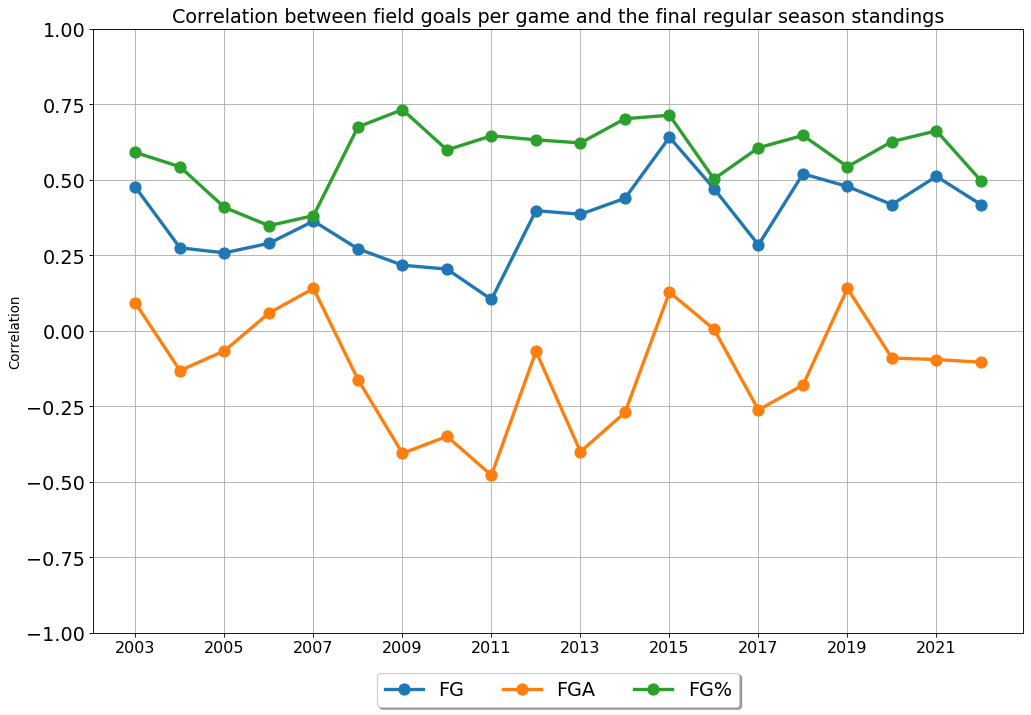

In [78]:
plot_stats_group(SEASONS, ["FG", "FGA", "FG%"], "field goals")

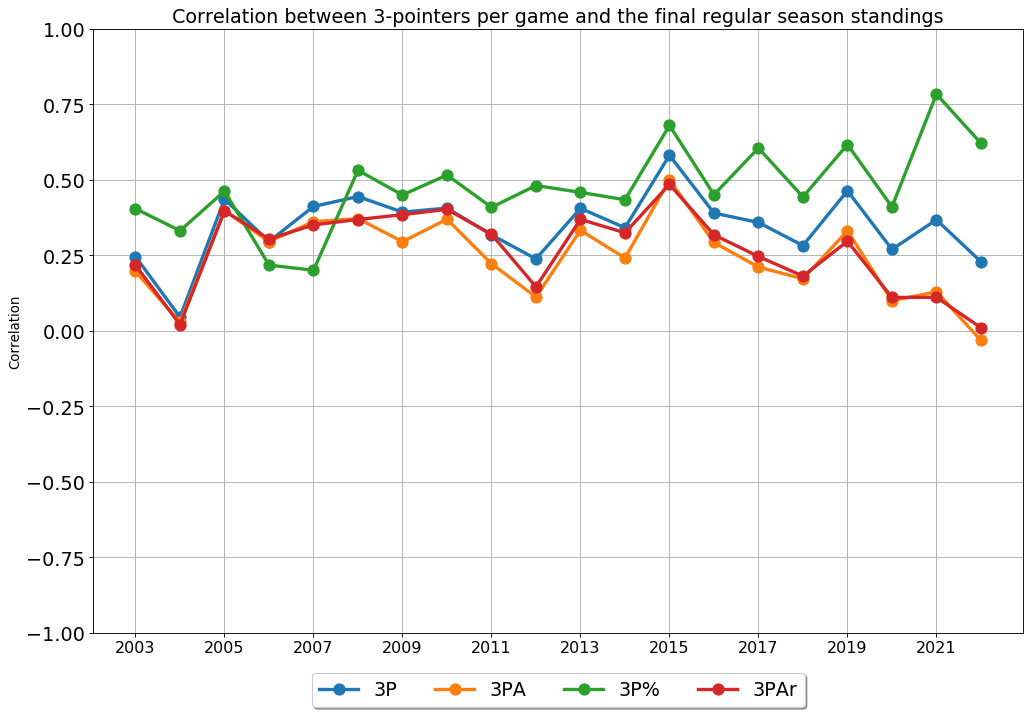

In [80]:
plot_stats_group(SEASONS, ["3P", "3PA", "3P%", "3PAr"], "3-pointers")

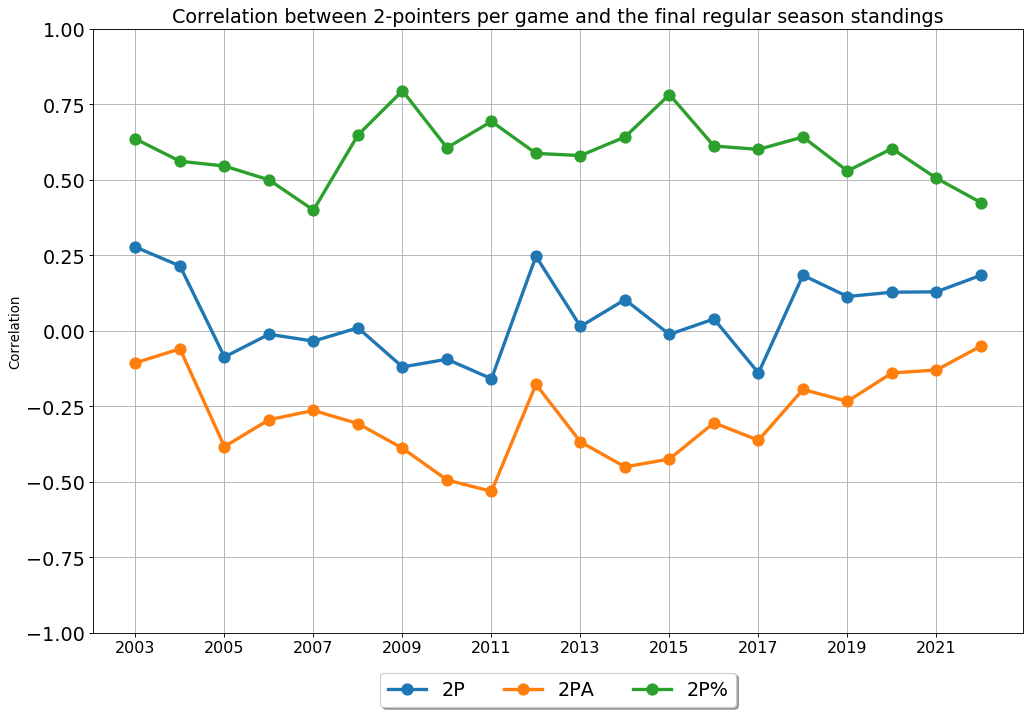

In [81]:
plot_stats_group(SEASONS, ["2P", "2PA", "2P%"], "2-pointers")

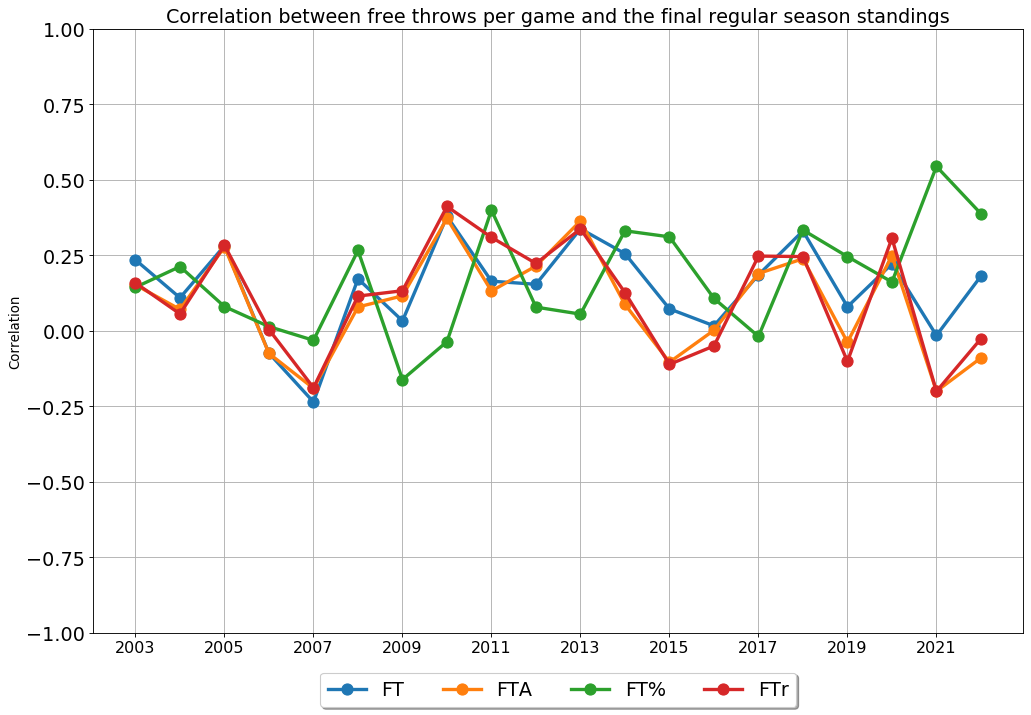

In [83]:
plot_stats_group(SEASONS, ["FT", "FTA", "FT%", "FTr"], "free throws")

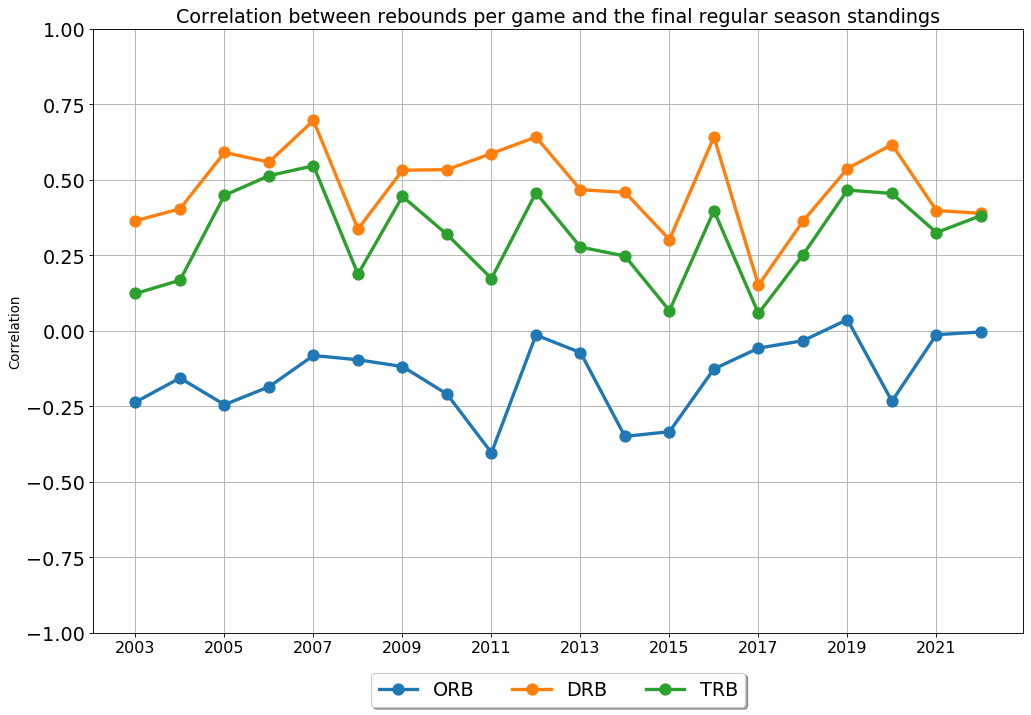

In [84]:
plot_stats_group(SEASONS, ["ORB", "DRB", "TRB"], "rebounds")

In [86]:
df.index

Index(['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg',
       'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'Off_eFG%', 'Off_TOV%',
       'Off_ORB%', 'Off_FT/FGA', 'Def_eFG%', 'Def_TOV%', 'Def_DRB%',
       'Def_FT/FGA', 'Arena', 'Attend.', 'Attend./G'],
      dtype='object', name='Stat')

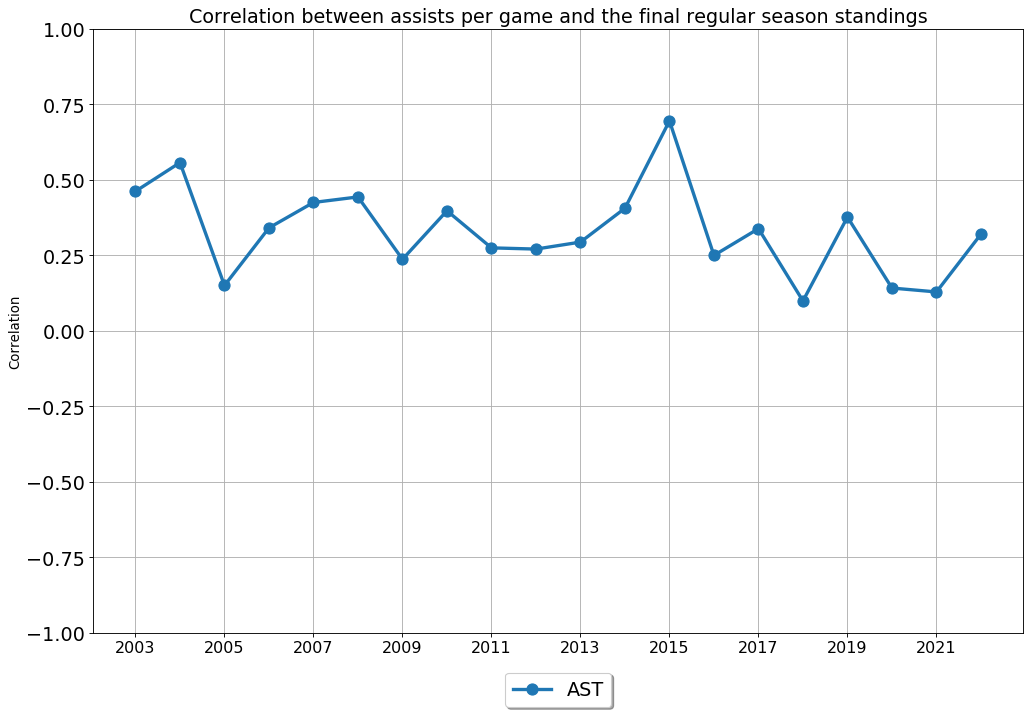

In [87]:
plot_stats_group(SEASONS, ["AST"], "assists")

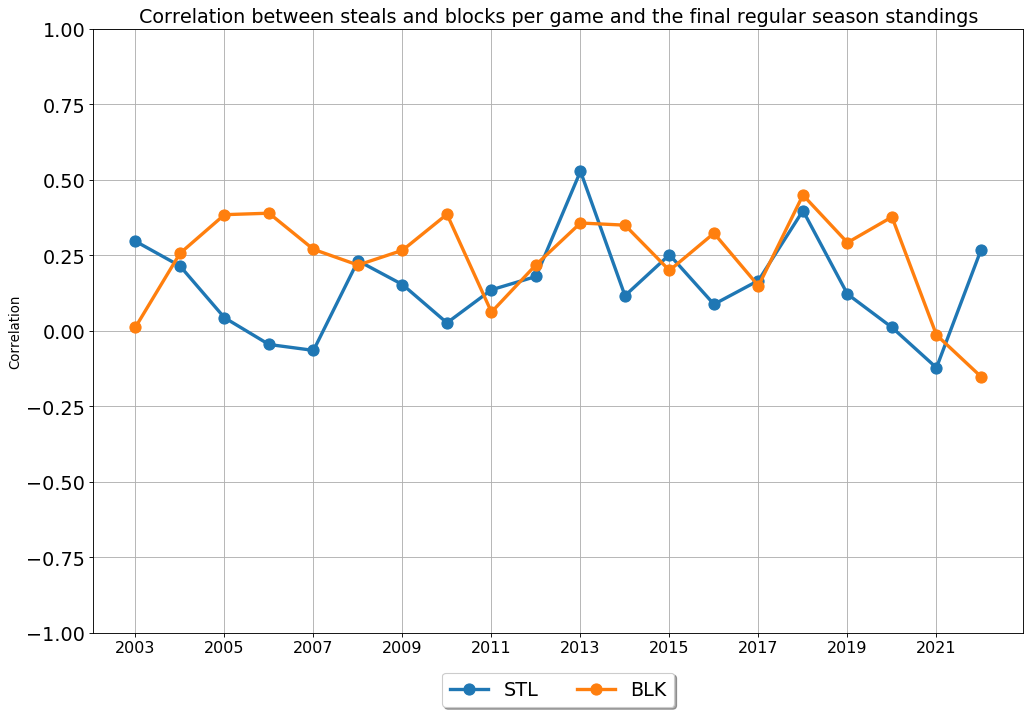

In [88]:
plot_stats_group(SEASONS, ["STL", "BLK"], "steals and blocks")

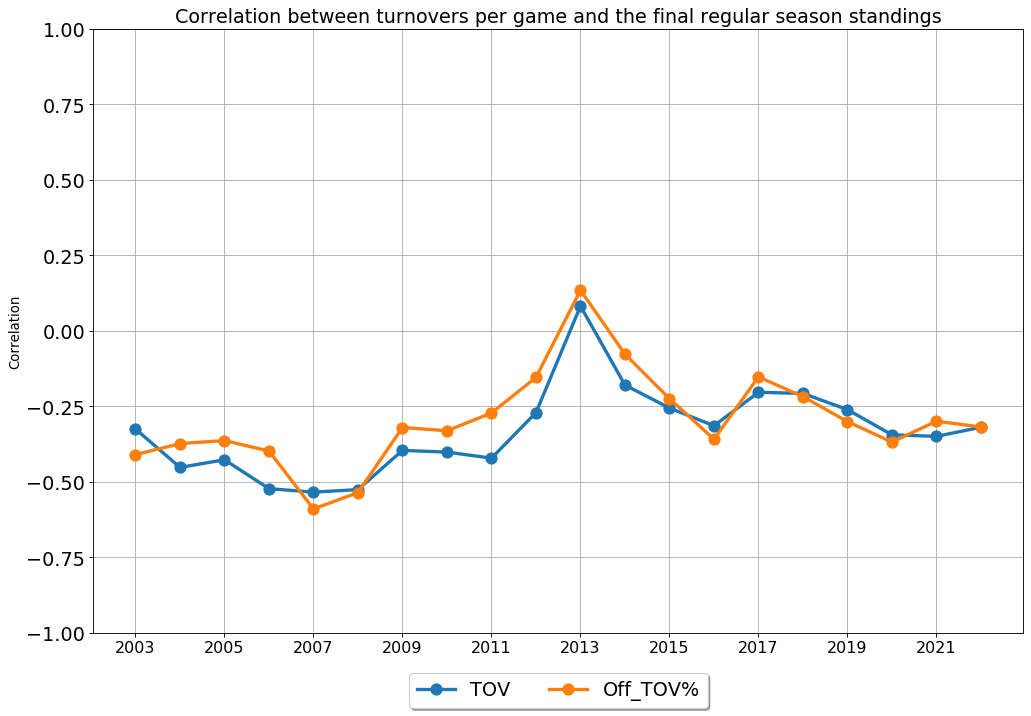

In [89]:
plot_stats_group(SEASONS, ["TOV", "Off_TOV%"], "turnovers")

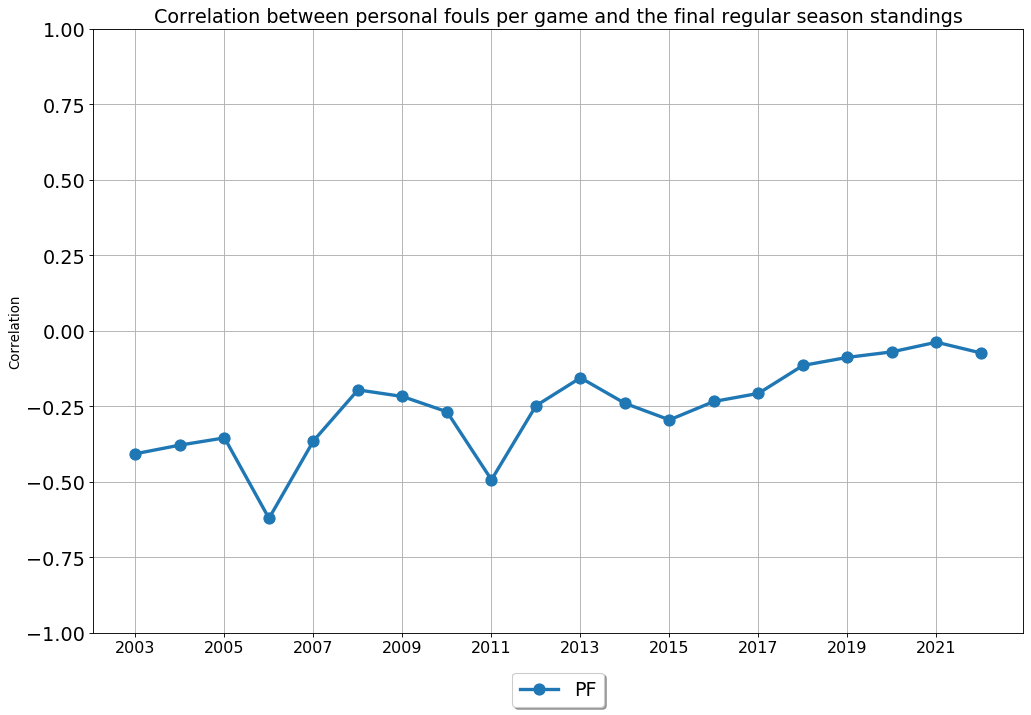

In [90]:
plot_stats_group(SEASONS, ["PF"], "personal fouls")

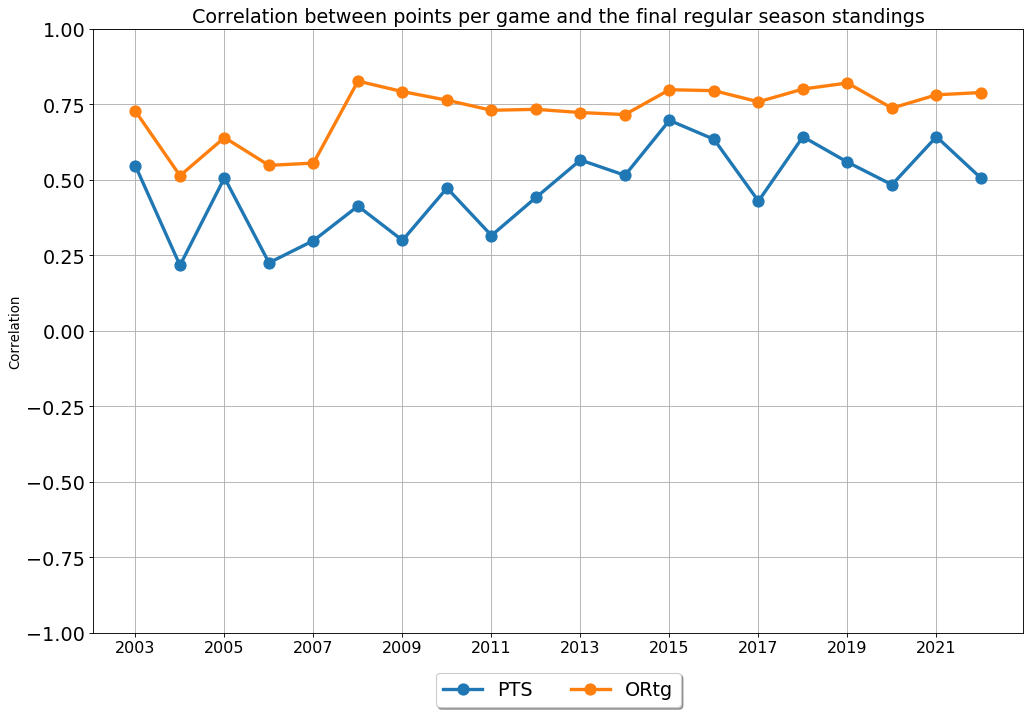

In [92]:
plot_stats_group(SEASONS, ["PTS", "ORtg"], "points")

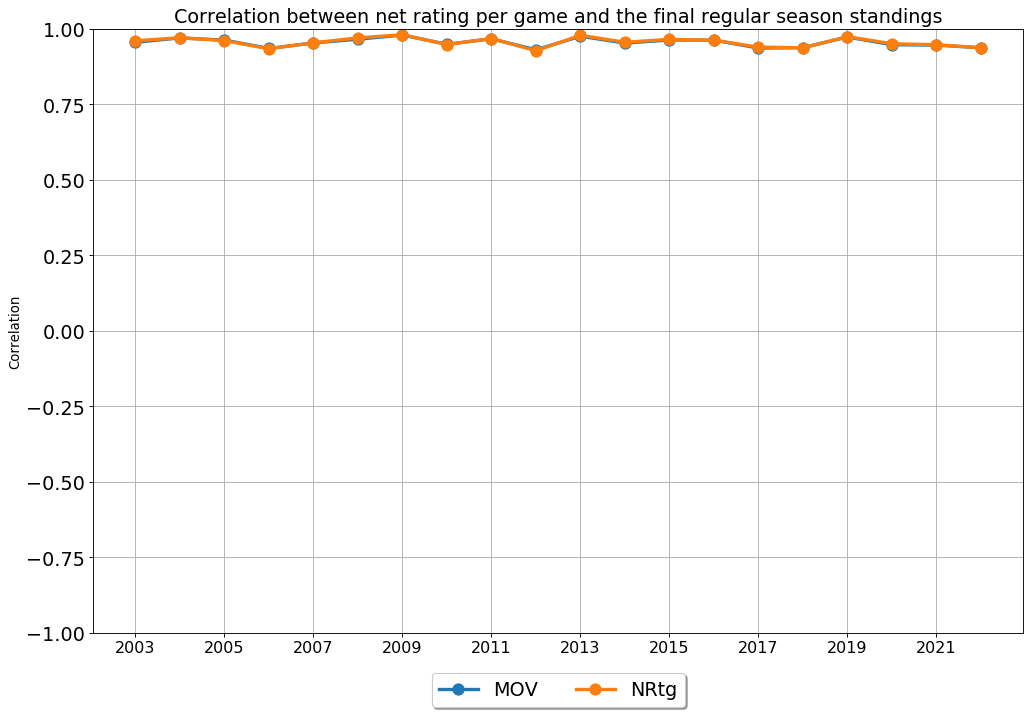

In [93]:
plot_stats_group(SEASONS, ["MOV", "NRtg"], "net rating")

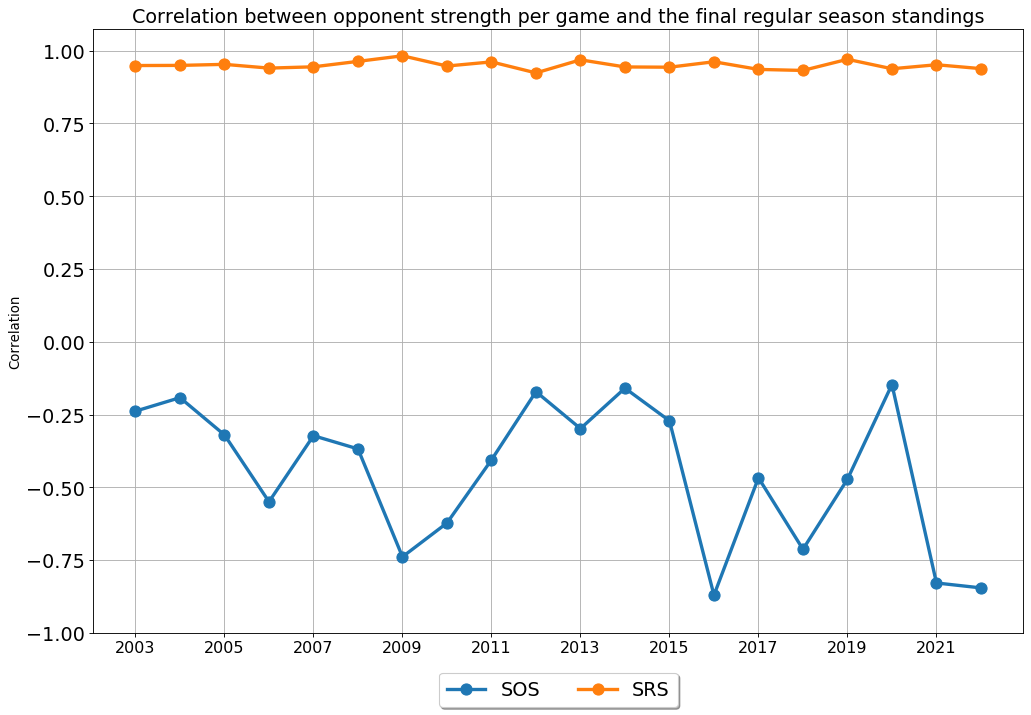

In [94]:
plot_stats_group(SEASONS, ["SOS", "SRS"], "opponent strength")

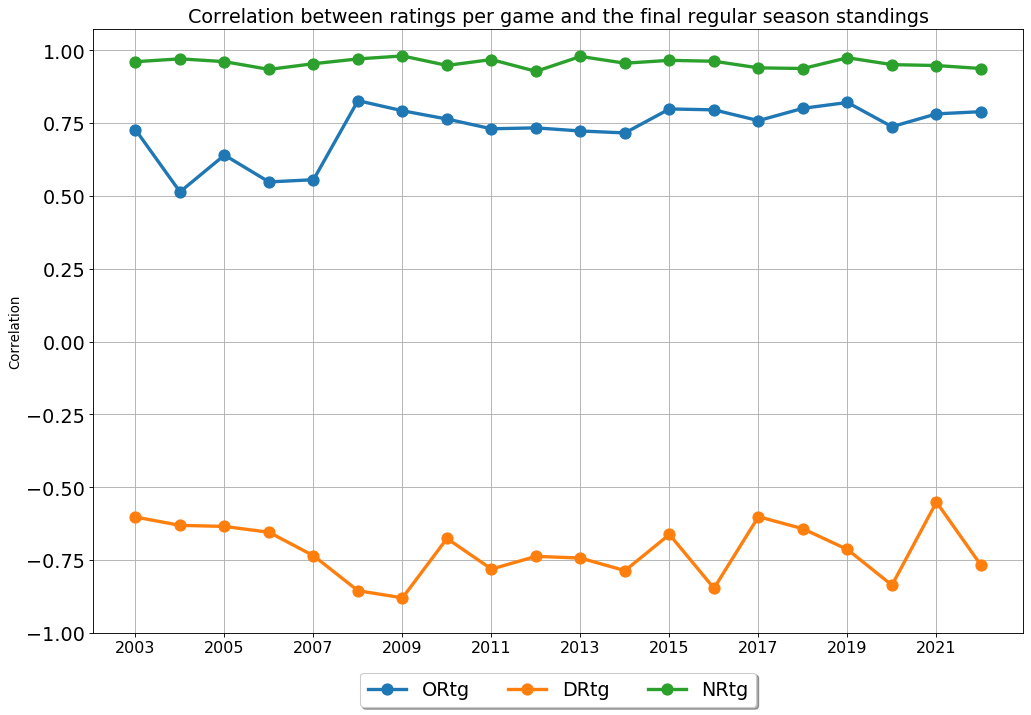

In [95]:
plot_stats_group(SEASONS, ["ORtg", "DRtg", "NRtg"], "ratings")

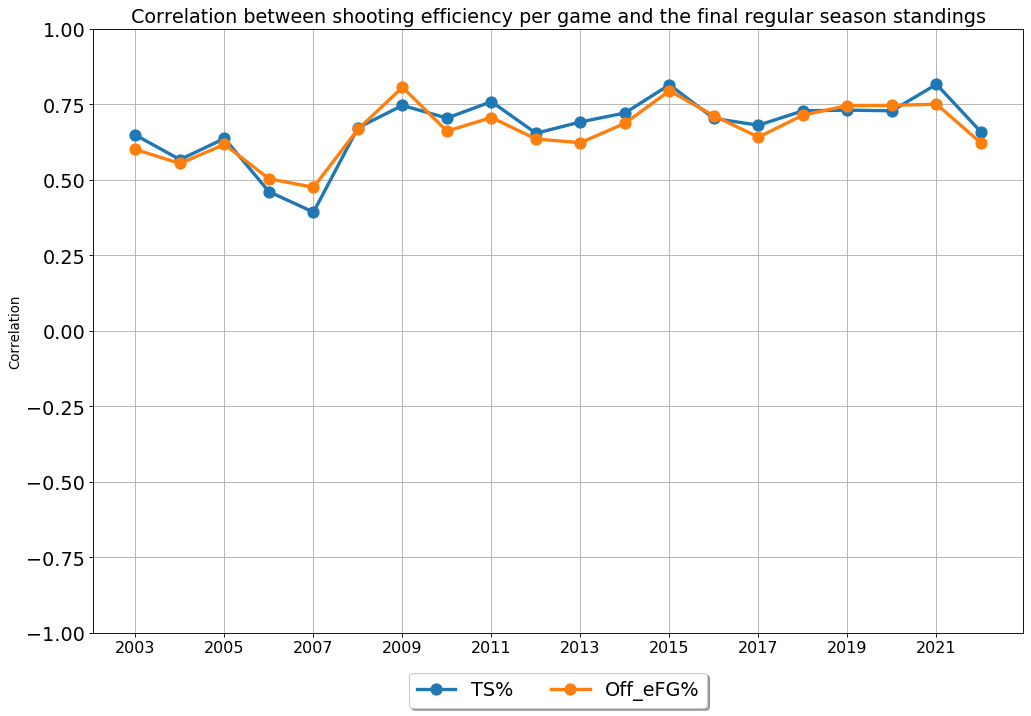

In [97]:
plot_stats_group(SEASONS, ["TS%", "Off_eFG%"], "shooting efficiency")

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Off_ORB%"], label="Offensive rebound%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between offensive rebound percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.grid()
plt.plot(SEASONS, df.loc["Off_FT/FGA"], label="Offensive free throw per field goal attempt")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between free throw per field goal attempt and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_eFG%"], label="Defensive eFG%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between defensive effective fiel goal percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_TOV%"], label="Defensive TO%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between defensive turnover percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_DRB%"], label="Defensive rebound%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between Defensive rebound percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_FT/FGA"], label="Defensive free throw per field goal attempt")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between free throw per field goal attempt on the defense and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Attend./G"], label="Attendance per game")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation betwee fan attendance per game and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
player_df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Player_Stats.xlsx")
player_df.set_index(["Stat", "Measure"], inplace=True)
player_df

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["Age", "mean"], label="Age mean")
plt.plot(SEASONS, player_df.loc["Age", "max"], label="Max age")
plt.plot(SEASONS, player_df.loc["Age", "sd"], label="Age sd")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between age of the players and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["FG", "sd"], label="FG sd")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between made field goals standard deviation between the players and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["FTA", "max"], label="FTA max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between players with the most FTA and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["PTS", "mean"], label="PTS mean")
plt.plot(SEASONS, player_df.loc["PTS", "sd"], label="PTS sd")
plt.plot(SEASONS, player_df.loc["PTS", "max"], label="PTS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between PTS and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["PER", "mean"], label="PER mean")
plt.plot(SEASONS, player_df.loc["PER", "sd"], label="PER sd")
plt.plot(SEASONS, player_df.loc["PER", "max"], label="PER max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between PER and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["TS%", "mean"], label="TS% mean")
plt.plot(SEASONS, player_df.loc["TS%", "sd"], label="TS% sd")
plt.plot(SEASONS, player_df.loc["TS%", "max"], label="TS% max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between true shooting % and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["OWS", "mean"], label="OWS mean")
plt.plot(SEASONS, player_df.loc["OWS", "sd"], label="OWS sd")
plt.plot(SEASONS, player_df.loc["OWS", "max"], label="OWS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between offensive win share and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["DWS", "mean"], label="DWS mean")
plt.plot(SEASONS, player_df.loc["DWS", "sd"], label="DWS sd")
plt.plot(SEASONS, player_df.loc["DWS", "max"], label="DWS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between deffensive win share and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["WS", "mean"], label="WS mean")
plt.plot(SEASONS, player_df.loc["WS", "sd"], label="WS sd")
plt.plot(SEASONS, player_df.loc["WS", "max"], label="WS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between win share and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["USG%", "mean"], label="USG% mean")
plt.plot(SEASONS, player_df.loc["USG%", "sd"], label="USG% sd")
plt.plot(SEASONS, player_df.loc["USG%", "max"], label="USG% max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between usage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["Salary", "mean"], label="Salary mean")
plt.plot(SEASONS, player_df.loc["Salary", "sd"], label="Salary sd")
plt.plot(SEASONS, player_df.loc["Salary", "max"], label="Salary max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between salary and the final regular season standings")
plt.legend()
plt.show()